In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from matplotlib.gridspec import GridSpec

import numpy as np
import pandas as pd

import sys
import os

from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
BATCH_SIZE = 1

# setting the correct device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.set_default_device(device)

MAIN_PATH = '/home/u6/njcrutchfield/torch/NN/pill_data/pillQC-main/images' # images are 225 x 225 x 3

tensor_transform = transforms.ToTensor()
horizontal_flip = transforms.RandomHorizontalFlip(p=1)

# Dataset of both normal and horizontal flipped images
dataset = datasets.ImageFolder(MAIN_PATH, transform = tensor_transform) + datasets.ImageFolder(MAIN_PATH, transform=transforms.Compose([
                                                                                                                     tensor_transform,
                                                                                                                     horizontal_flip
                                                                                                                   ]))


In [3]:
SPLIT = [528, 66, 66]
train_set, _, _ = torch.utils.data.random_split(dataset,
                                                SPLIT,# 80%, 10%, 10%
                                                generator=torch.Generator(device=device))

loader = torch.utils.data.DataLoader(dataset = train_set,
                                            batch_size = BATCH_SIZE,
                                            shuffle = True,
                                            generator=torch.Generator(device=device))

In [4]:
class Encoder(nn.Module):
    def __init__(self, in_channel=3, out_channel=3500, activation=nn.GELU()):
        super().__init__()
        # The input size is 3*225*225
        self.in_channel = in_channel
        self.out_channel = out_channel
        self.encoder = nn.Sequential(
                                nn.Conv2d(in_channels=in_channel,out_channels=16,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(16), 
                                activation,
            
                                nn.Conv2d(in_channels=16,out_channels=32,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(32), 
                                activation,
            
                                nn.Conv2d(in_channels=32,out_channels=32,kernel_size=2,stride=2,padding=1,bias=False),
                                nn.BatchNorm2d(32), 
                                activation,
            
                                nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(64), 
                                activation,
            
                                nn.Conv2d(in_channels=64,out_channels=64,kernel_size=2,stride=2,padding=1,bias=False),
                                nn.BatchNorm2d(64), 
                                activation,
            
                                nn.Conv2d(in_channels=64,out_channels=128,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(128), 
                                activation,
            
                                nn.Conv2d(in_channels=128,out_channels=128,kernel_size=2,stride=2,padding=1,bias=False),
                                nn.BatchNorm2d(128), 
                                activation,
            
                                nn.Conv2d(in_channels=128,out_channels=320,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(320), 
                                activation,
            
                                nn.Conv2d(in_channels=320,out_channels=240,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(240), 
                                activation,
            
                                nn.Conv2d(in_channels=240,out_channels=150,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(150), 
                                activation,
            
                                nn.Conv2d(in_channels=150,out_channels=80,kernel_size=3,stride=2,padding=1,bias=False),
                                nn.BatchNorm2d(80), 
                                activation,
            
                                nn.Conv2d(in_channels=80,out_channels=40,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(40), 
                                activation,
            
                                nn.Conv2d(in_channels=40,out_channels=15,kernel_size=3,stride=1,padding=1,bias=False),
                                nn.BatchNorm2d(15), 
                                activation,
            
                                nn.Flatten(),
                                nn.Linear(in_features=15*15*15, out_features=out_channel),
                                nn.Softmax(dim=1))
        
    def forward(self, x):
        x = x.view(-1, self.in_channel, 225, 225)
        prob = self.encoder(x)
        return prob


class Decoder(nn.Module):
    def __init__(self, in_channel=3, out_channel=1600, activation=nn.GELU()):
        super().__init__()
        self.in_channel = in_channel
        self.out_channel = out_channel

        self.mlp = nn.Sequential(
                             nn.Linear(in_features=out_channel, out_features=15*15*15, bias=False),
                             nn.BatchNorm1d(15*15*15),
                             activation,
                             nn.Unflatten(1, (15, 15, 15)))
        
        self.decoder = nn.Sequential(
                                nn.ConvTranspose2d(in_channels=15,out_channels=40,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(40), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=40,out_channels=80,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(80), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=80,out_channels=150,kernel_size=3,stride=2,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(150), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=150,out_channels=240,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(240), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=240,out_channels=320,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(320), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=320,out_channels=128,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(128), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=128,out_channels=128,kernel_size=3,stride=2,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(128), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=128,out_channels=64,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(64), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=64,out_channels=64,kernel_size=3,stride=2,padding=2,output_padding=0,bias=False),
                                nn.BatchNorm2d(64), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=64,out_channels=32,kernel_size=3,stride=1,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(32), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=32,out_channels=32,kernel_size=3,stride=2,padding=1,output_padding=0,bias=False),
                                nn.BatchNorm2d(32), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=32,out_channels=16,kernel_size=3,stride=1,padding=0,output_padding=0,bias=False),
                                nn.BatchNorm2d(16), 
                                activation,
            
                                nn.ConvTranspose2d(in_channels=16, out_channels=in_channel, kernel_size=3, stride=1, padding=0, output_padding=0),
                                nn.Sigmoid())
    
    def forward(self, x):
        x = x.view(-1, self.out_channel)
        temp = self.mlp(x)
        temp = temp.view(-1,15,15,15)
        output = self.decoder(temp)
        return output

In [5]:
enc_out = 64
encoder = Encoder(out_channel = enc_out)

rand_mat_dim = 32
decoder = Decoder(out_channel = rand_mat_dim)

In [6]:
rand_mat = torch.randn(rand_mat_dim, enc_out, requires_grad=False, device='cuda' if torch.cuda.is_available() else 'cpu')
rand_mat = rand_mat.div(torch.norm(rand_mat, dim = 0))

In [7]:
class AE(torch.nn.Module):
    def __init__(self, encoder, decoder, rand_mat):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.rand_mat = rand_mat
        
    def forward(self, x):
        enc = encoder(x)
        all_dps = []
        for batch in enc:
            all_dps.append(torch.mv(self.rand_mat, batch))
        Dp = torch.stack(all_dps)
        
        p_vec = F.softmax(Dp, dim = 1)
        
        
        
        dec = decoder(p_vec)
        return dec, p_vec

In [8]:
rand_mat

tensor([[ 0.1727,  0.0281,  0.1295,  ..., -0.2356,  0.0676,  0.1499],
        [-0.1934, -0.0373,  0.1680,  ..., -0.1397, -0.3615,  0.0286],
        [-0.1730, -0.1590,  0.0842,  ...,  0.1569,  0.1269, -0.1551],
        ...,
        [-0.2495, -0.0235, -0.0161,  ..., -0.0684,  0.1114,  0.1527],
        [ 0.1237, -0.2569, -0.1087,  ...,  0.1069,  0.2342,  0.0995],
        [-0.1924, -0.1728, -0.3714,  ..., -0.1395,  0.3537, -0.0920]],
       device='cuda:0')

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = Encoder(out_channel = enc_out)
decoder = Decoder(out_channel = rand_mat_dim)
temp = torch.randn(rand_mat_dim, enc_out, requires_grad=False, device='cuda' if torch.cuda.is_available() else 'cpu')
temp = rand_mat.div(torch.norm(rand_mat, dim = 0))

model = AE(encoder, decoder, rand_mat=temp).to(device)
model.load_state_dict(torch.load('./models/scae_model_gs.pth'))
model.rand_mat = torch.load('./models/scae_model_rand_mat.pth')

# setting the encoder and decoder for visualization
encoder = model.encoder
decoder = model.decoder
rand_mat = model.rand_mat

In [10]:
# input and output arrays
encoded_imgs_arr = []
label_arr = []
img_arr = []
torch.set_default_device('cuda')

for (inp, label) in loader:
    model.eval()
    with torch.no_grad():
        inp = inp.to(device)
        oup, p_vec = model(inp)
        
        # append the p_vec as numpy array, returned as [[]], make into []
        encoded_imgs_arr.append(p_vec.cpu().numpy()[0])
        label_arr.append(label.item())
        img_arr.append(inp.cpu().numpy()[0])




In [11]:
n_clusters_arr = [i for i in range(3, 15)]

max_dict = {"k": 0, "avg": -2}

for k in n_clusters_arr:
    k_mean = KMeans(n_clusters=k)
    k_labels = k_mean.fit_predict(encoded_imgs_arr)
    
    # https://scikit-learn.org/dev/modules/generated/sklearn.metrics.pairwise.distance_metrics.html
    sil_avg = silhouette_score(encoded_imgs_arr, k_labels, metric="cosine")
    if max_dict["avg"] < sil_avg:
        max_dict["k"] = k
        max_dict["avg"] = sil_avg
    print(f'{k=}: {sil_avg=}')
    
print(f"{max_dict=}")

k=3: sil_avg=0.3642992
k=4: sil_avg=0.44624034
k=5: sil_avg=0.49495402
k=6: sil_avg=0.53383476
k=7: sil_avg=0.5096051
k=8: sil_avg=0.46949565
k=9: sil_avg=0.45377147
k=10: sil_avg=0.44093266
k=11: sil_avg=0.42344037
k=12: sil_avg=0.40924054
k=13: sil_avg=0.41010064
k=14: sil_avg=0.37979615
max_dict={'k': 6, 'avg': 0.53383476}


In [12]:
k =  max_dict["k"]
kmeans = KMeans(n_clusters=k)
kmeans.fit(encoded_imgs_arr)
print(f"Sum of squared distance to closest cluster center: {kmeans.inertia_:.10f}")

Sum of squared distance to closest cluster center: 0.0001208955


In [13]:
tsne = TSNE(n_components=2)
tsne_results = tsne.fit_transform(encoded_imgs_arr) # fit_transform or fit?

/opt/ohpc/pub/apps/python/3.8.12/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/opt/ohpc/pub/apps/python/3.8.12/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [14]:
col_names = ["X T-SNE", "Y T-SNE", 
             "True Label", "K-means Grouping", "Color T", "Color K", "Img Data"]
df = pd.DataFrame(list(zip(tsne_results[:,0],            # x tsne
                           tsne_results[:,1],            # y tsne
                           label_arr,                    # true label
                           kmeans.labels_,               # k-mean label
                           kmeans.labels_,               # temp for colors
                           kmeans.labels_,               # temp for colors
                           img_arr)),                    # imgs             
                 columns=col_names)

colors = list(mcolors.TABLEAU_COLORS)
for i in range(k):
    df.loc[df["K-means Grouping"] == i, "Color K"] = colors[i]

for i in range(max(label_arr) - min(label_arr) + 1):
    df.loc[df["True Label"] == i, "Color T"] = colors[i]


In [15]:
df.head()

,X T-SNE,Y T-SNE,True Label,K-means Grouping,Color T,Color K,Img Data
0,-25.003700,17.192904,1,0,tab:orange,tab:blue,"[[[0.24705882, 0.29803923, 0.3019608, 0.282352..."
1,-6.269907,20.131538,2,1,tab:green,tab:orange,"[[[0.53333336, 0.4627451, 0.39607844, 0.372549..."
2,-9.816598,8.576821,1,3,tab:orange,tab:red,"[[[0.3254902, 0.3137255, 0.3019608, 0.30588236..."
3,-9.208416,18.968607,2,1,tab:green,tab:orange,"[[[0.38039216, 0.3764706, 0.3764706, 0.3843137..."
4,26.853294,35.895405,2,4,tab:green,tab:purple,"[[[0.45490196, 0.41960785, 0.3647059, 0.352941..."


In [17]:
amt_imgs = 10
k_img_arr = []
t_img_arr = []

# Populate img_arr with 3 items, of amt_imgs imgs per item
# Note the index will be the corresponding k
for k_temp, df_group in df.groupby("K-means Grouping"):
    k_img_arr.append(list(df_group["Img Data"])[:amt_imgs])

# Populate img_arr with 3 items, of amt_imgs imgs per item
# Note the index will be the corresponding label
for t_temp, df_group in df.groupby("True Label"):
    t_img_arr.append(list(df_group["Img Data"])[:amt_imgs])

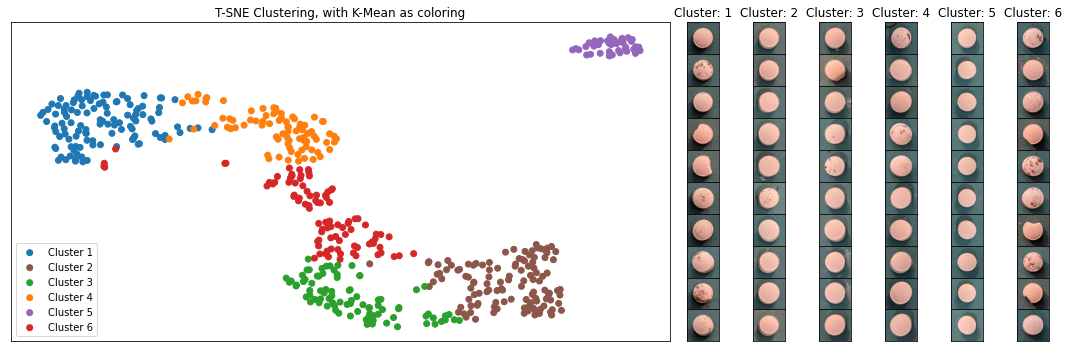

In [36]:
fig = plt.figure(figsize=(15,5))

widths = [0.125] + [(0.075/k) for i in range(k)]
gs = fig.add_gridspec(amt_imgs, k+1, width_ratios=widths, wspace=0, hspace=0)
 
# create sub plots as grid
ax = fig.add_subplot(gs[:, 0])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for color, df_group in df.groupby("Color K"):
    plt.scatter(df_group["X T-SNE"], df_group["Y T-SNE"], c=df_group["Color K"], 
                label=f"Feature {color}")
ax.set_title("T-SNE Clustering, with K-Mean as coloring")
legend_arr = [f"Cluster {i+1}" for i in range(k)]
plt.legend(legend_arr)

# Loop across cols
for j in range(1, k+1):
    # Loop across row
    for i in range(0,amt_imgs):
        # Create new subplot
        ax = fig.add_subplot(gs[i, j])
        if i == 0:
            ax.set_title(f"Cluster: {j}")
        
        # Remove axis ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        img = k_img_arr[j-1][i]
        plt.imshow(np.transpose(img, (1,2,0)))

# Display the plots
plt.tight_layout()
plt.show()

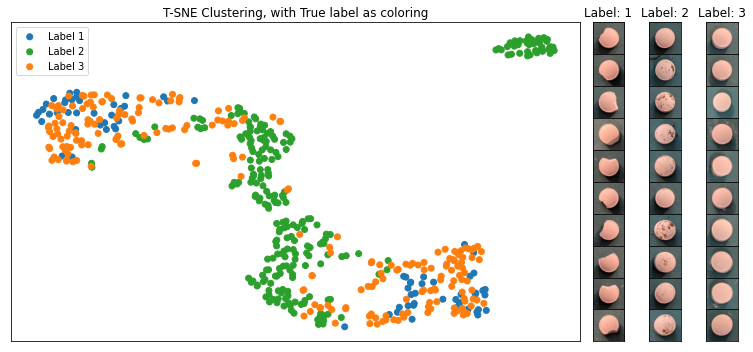

In [38]:
fig = plt.figure(figsize=(13,5))

widths = [0.125] + [(0.075/k) for i in range(k)]
gs = fig.add_gridspec(amt_imgs, k+1, width_ratios=widths, wspace=0, hspace=0)
 
# create sub plots as grid
ax = fig.add_subplot(gs[:, 0])
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
for color, df_group in df.groupby("Color T"):
    plt.scatter(df_group["X T-SNE"], df_group["Y T-SNE"], c=df_group["Color T"], 
                label=f"Feature {color}")
    
plt.xticks([])  
plt.yticks([])
plt.title("T-SNE Clustering, with True label as coloring")

legend_arr = [f"Label {i+1}" for i in range(max(label_arr) - min(label_arr) +1)]
plt.legend(legend_arr)

# Loop across cols
for j in range(1, 4):
    # Loop across row
    for i in range(0,amt_imgs):
        # Create new subplot
        ax = fig.add_subplot(gs[i, j])
        if i == 0:
            ax.set_title(f"Label: {j}")
        
        # Remove axis ticks
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
        img = t_img_arr[j-1][i]
        plt.imshow(np.transpose(img, (1,2,0)))

# Display the plots
plt.tight_layout()
plt.show()

In [20]:
kmeans = KMeans(n_clusters=3)
kmeans.fit(encoded_imgs_arr)
print(f"Sum of squared distance to closest cluster center: {kmeans.inertia_:.10f}")

Sum of squared distance to closest cluster center: 0.0002283249


In [28]:
col_names_3 = ["True Label", "K-means Grouping", "Color T", "Color K", "Img Data"]
df_k_is_3 = pd.DataFrame(list(zip(
                           label_arr,                    # true label
                           kmeans.labels_,               # k-mean label
                           kmeans.labels_,               # temp for colors
                           kmeans.labels_,               # temp for colors
                           img_arr)),                    # imgs             
                 columns=col_names_3)

colors = list(mcolors.TABLEAU_COLORS)
for i in range(3):
    df_k_is_3.loc[df_k_is_3["K-means Grouping"] == i, "Color K"] = colors[i]

for i in range(max(label_arr) - min(label_arr) + 1):
    df_k_is_3.loc[df_k_is_3["True Label"] == i, "Color T"] = colors[i]

In [29]:
df_k_is_3.head()

,True Label,K-means Grouping,Color T,Color K,Img Data
0,1,0,tab:orange,tab:blue,"[[[0.24705882, 0.29803923, 0.3019608, 0.282352..."
1,2,0,tab:green,tab:blue,"[[[0.53333336, 0.4627451, 0.39607844, 0.372549..."
2,1,1,tab:orange,tab:orange,"[[[0.3254902, 0.3137255, 0.3019608, 0.30588236..."
3,2,0,tab:green,tab:blue,"[[[0.38039216, 0.3764706, 0.3764706, 0.3843137..."
4,2,0,tab:green,tab:blue,"[[[0.45490196, 0.41960785, 0.3647059, 0.352941..."


In [32]:
# k must be 3
# the array is true color, the dict is the counter for its k-colors
true_color_3 = [{"tab:orange": 0, "tab:blue": 0, "tab:green": 0}, 
         {"tab:orange": 0, "tab:blue": 0, "tab:green": 0}, 
         {"tab:orange": 0, "tab:blue": 0, "tab:green": 0}]  # 0: orange, 1: blue, 2:green

for i in range(len(df_k_is_3)):
    t = df_k_is_3.iloc[i]["Color T"]
    k_temp = df_k_is_3.iloc[i]["Color K"]
    
    if t == "tab:orange":
        true_color_3[0][k_temp] += 1
    elif t == "tab:blue":
        true_color_3[1][k_temp] += 1
    else:
        true_color_3[2][k_temp] += 1

best_orange = list(filter(lambda x: true_color_3[0][x] == max(true_color_3[0].values()), true_color_3[0]))[0]
best_blue = list(filter(lambda x: true_color_3[1][x] == max(true_color_3[1].values()), true_color_3[1]))[0]
best_green = list(filter(lambda x: true_color_3[2][x] == max(true_color_3[2].values()), true_color_3[2]))[0]
print(f"True Color: orange {true_color_3[0]}\nTrue Color: blue {true_color_3[1]}\nTrue Color: green {true_color_3[2]}\n\n")
print(f"Best mapping (T: K):\ntab:orange:\t{best_orange}\ntab:blue:\t{best_blue}\ntab:green:\t{best_green}")

True Color: orange {'tab:orange': 34, 'tab:blue': 87, 'tab:green': 94}
True Color: blue {'tab:orange': 3, 'tab:blue': 34, 'tab:green': 35}
True Color: green {'tab:orange': 123, 'tab:blue': 74, 'tab:green': 44}


Best mapping (T: K):
tab:orange:	tab:green
tab:blue:	tab:green
tab:green:	tab:orange


In [34]:
# notice that blue and orange map to green, choose the one that will improve accuracy
best_blue = "tab:blue"
print(f"Best mapping (T: K):\ntab:orange:\t{best_orange}\ntab:blue:\t{best_blue}\ntab:green:\t{best_green}")

Best mapping (T: K):
tab:orange:	tab:green
tab:blue:	tab:blue
tab:green:	tab:orange


In [35]:
# k must be 3
# Using the best grouping for each, calculate the accuracy
correct_sum = 0
for i in range(len(df_k_is_3)):
    t = df_k_is_3.iloc[i]["Color T"]
    k_temp = df_k_is_3.iloc[i]["Color K"]
    
    if t == "tab:orange" and k_temp == best_orange:
        correct_sum += 1
    elif t == "tab:blue" and k_temp == best_blue:
        correct_sum += 1
    elif t == "tab:green" and k_temp == best_green:
        correct_sum += 1

print(f"Accuracy: {(correct_sum/len(df)*100):.2f}%")

Accuracy: 47.54%
